# Model Selection & Forecast Pipeline

### Import and Setup

In [2]:
import sys
import os

# Add project root to Python path so we can import from src/
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.ensemble import HistGradientBoostingRegressor
from src.metrics import mae, rmse, mape

In [4]:
RANDOM_STATE = 42

In [5]:
# load processed setup
df = pd.read_csv(
    "../data/processed/hourly_energy.csv",
    parse_dates=["datetime"],
    index_col="datetime"
).sort_index()

df.head()

,Global_active_power
datetime,
2006-12-16 17:00:00,4.2229
2006-12-16 18:00:00,3.6322
2006-12-16 19:00:00,3.4002
2006-12-16 20:00:00,3.2686
2006-12-16 21:00:00,3.0565


In [6]:
target = "Global_active_power"

### Feature Engineering v2

In [7]:
# base time features 
df_feat = df.copy()

df_feat["hour"] = df_feat.index.hour
df_feat["dayofweek"] = df_feat.index.dayofweek
df_feat["month"] = df_feat.index.month

In [8]:
# lag features 
df_feat["lag_1"] = df_feat[target].shift(1)
df_feat["lag_24"] = df_feat[target].shift(24)
df_feat["lag_168"] = df_feat[target].shift(168)

In [9]:
# rolling features 

# rolling mean(24hr)
df_feat["rolling_mean_24"] = (
    df_feat[target]
    .shift(1)
    .rolling(window=24)
    .mean()
)

# rolling std(24hr)
df_feat["rolling_std_24"] = (
    df_feat[target]
    .shift(1)
    .rolling(window=24)
    .std()
)

# rolling mean(7days = 168hours)
df_feat["rolling_mean_168"] = (
    df_feat[target]
    .shift(1)
    .rolling(window=168)
    .mean()
)

In [10]:
# cyclical encoding
df_feat["hour_sin"] = np.sin(2 * np.pi * df_feat["hour"] / 24)
df_feat["hour_cos"] = np.cos(2 * np.pi * df_feat["hour"] / 24)

In [11]:
# drop NaNs
df_feat = df_feat.dropna()
df_feat.shape

(34421, 12)

### Time Split

In [12]:
# create X and y
feature_cols = [
    "dayofweek",
    "month",
    "hour_sin",
    "hour_cos",
    "lag_1",
    "lag_24",
    "lag_168",
    "rolling_mean_24",
    "rolling_std_24",
    "rolling_mean_168"
]

X = df_feat[feature_cols]
y = df_feat[target]

X.head(), y.head()

(                     dayofweek  month  hour_sin      hour_cos   lag_1  lag_24  \
 datetime                                                                        
 2006-12-23 17:00:00          5     12 -0.965926 -2.588190e-01  4.3491  1.4968   
 2006-12-23 18:00:00          5     12 -1.000000 -1.836970e-16  5.4525  2.6870   
 2006-12-23 19:00:00          5     12 -0.965926  2.588190e-01  3.8794  3.9382   
 2006-12-23 20:00:00          5     12 -0.866025  5.000000e-01  4.1178  3.5361   
 2006-12-23 21:00:00          5     12 -0.707107  7.071068e-01  4.1814  4.5487   
 
                      lag_168  rolling_mean_24  rolling_std_24  \
 datetime                                                        
 2006-12-23 17:00:00   4.2229         2.934900        0.990192   
 2006-12-23 18:00:00   3.6322         3.099721        1.066674   
 2006-12-23 19:00:00   3.4002         3.149404        1.074357   
 2006-12-23 20:00:00   3.2686         3.156887        1.080697   
 2006-12-23 21:00:00   3.056

In [14]:
n = len(df_feat)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

### Train GradientBoosting on Train Only

In [15]:
# define model
hgb = HistGradientBoostingRegressor(
    max_iter=200,
    learning_rate=0.1,
    max_depth=None,
    random_state=RANDOM_STATE
)

hgb.fit(X_train, y_train)

,"loss loss: {'squared_error', 'absolute_error', 'gamma', 'poisson', 'quantile'}, default='squared_error'The loss function to use in the boosting process. Note that the""squared error"", ""gamma"" and ""poisson"" losses actually implement""half least squares loss"", ""half gamma deviance"" and ""half poissondeviance"" to simplify the computation of the gradient. Furthermore,""gamma"" and ""poisson"" losses internally use a log-link, ""gamma""requires ``y > 0`` and ""poisson"" requires ``y >= 0``.""quantile"" uses the pinball loss... versionchanged:: 0.23 Added option 'poisson'... versionchanged:: 1.1 Added option 'quantile'... versionchanged:: 1.3 Added option 'gamma'.",'squared_error'
,"quantile quantile: float, default=NoneIf loss is ""quantile"", this parameter specifies which quantile to be estimatedand must be between 0 and 1.",None
,"learning_rate learning_rate: float, default=0.1The learning rate, also known as *shrinkage*. This is used as amultiplicative factor for the leaves values. Use ``1`` for noshrinkage.",0.1
,"max_iter max_iter: int, default=100The maximum number of iterations of the boosting process, i.e. themaximum number of trees.",200
,"max_leaf_nodes max_leaf_nodes: int or None, default=31The maximum number of leaves for each tree. Must be strictly greaterthan 1. If None, there is no maximum limit.",31
,"max_depth max_depth: int or None, default=NoneThe maximum depth of each tree. The depth of a tree is the number ofedges to go from the root to the deepest leaf.Depth isn't constrained by default.",None
,"min_samples_leaf min_samples_leaf: int, default=20The minimum number of samples per leaf. For small datasets with lessthan a few hundred samples, it is recommended to lower this valuesince only very shallow trees would be built.",20
,"l2_regularization l2_regularization: float, default=0The L2 regularization parameter penalizing leaves with small hessians.Use ``0`` for no regularization (default).",0.0
,"max_features max_features: float, default=1.0Proportion of randomly chosen features in each and every node split.This is a form of regularization, smaller values make the trees weakerlearners and might prevent overfitting.If interaction constraints from `interaction_cst` are present, only allowedfeatures are taken into account for the subsampling... versionadded:: 1.4",1.0
,"max_bins max_bins: int, default=255The maximum number of bins to use for non-missing values. Beforetraining, each feature of the input array `X` is binned intointeger-valued bins, which allows for a much faster training stage.Features with a small number of unique values may use less than``max_bins`` bins. In addition to the ``max_bins`` bins, one more binis always reserved for missing values. Must be no larger than 255.",255
,"categorical_features categorical_features: array-like of {bool, int, str} of shape (n_features) or shape (n_categorical_features,), default='from_dtype'Indicates the categorical features.- None : no feature will be considered categorical.- boolean array-like : boolean mask indicating categorical features.- integer array-like : integer indices indicating categorical features.- str array-like: names of categorical features (assuming the training data has feature names).- `""from_dtype""`: dataframe columns with dtype ""category"" are considered to be categorical features. The input must be an object exposing a ``__dataframe__`` method such as pandas or polars DataFrames to use this feature.For each categorical feature, there must be at most `max_bins` uniquecategories. Negative values for categorical features encoded as numericdtypes are treated as missing values. All categorical values areconverted to floating point numbers. This means that categorical valuesof 1.0 and 1 are treated as the same category.Read more in the :ref:`User Guide ` and:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_categorical.py`... versionadded:: 0.24.. versionchanged:: 1.2 Added support for feature names... versionchanged:: 

In [16]:
# Evaluate on Train + Validation
y_train_pred = hgb.predict(X_train)
y_val_pred = hgb.predict(X_val)

train_metrics = {
    "MAE": mae(y_train, y_train_pred),
    "RMSE": rmse(y_train, y_train_pred),
    "MAPE": mape(y_train, y_train_pred),
}

val_metrics = {
    "MAE": mae(y_val, y_val_pred),
    "RMSE": rmse(y_val, y_val_pred),
    "MAPE": mape(y_val, y_val_pred),
}

train_metrics, val_metrics

({'MAE': 0.3511642018435467,
  'RMSE': np.float64(0.5180229629085586),
  'MAPE': np.float64(45.76974574539241)},
 {'MAE': 0.37413413733900963,
  'RMSE': np.float64(0.5385525173217125),
  'MAPE': np.float64(40.246857560771765)})

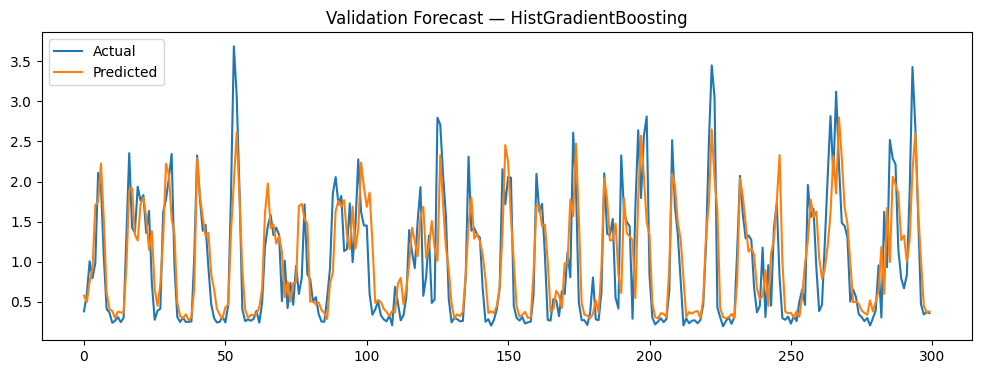

In [17]:
# plot for validation
plt.figure(figsize=(12, 4))
plt.plot(y_val.values[:300], label="Actual")
plt.plot(y_val_pred[:300], label="Predicted")
plt.title("Validation Forecast — HistGradientBoosting")
plt.legend()
plt.show()

### Retrain GradientBoosting on Train + Validation

In [18]:
# combine train and val
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

len(X_train_full), len(y_train_full)

(29257, 29257)

In [19]:
# reinitialize the final model
final_model = HistGradientBoostingRegressor(
    max_iter=200,
    learning_rate=0.1,
    max_depth=None,
    random_state=RANDOM_STATE
)

In [20]:
final_model.fit(X_train_full, y_train_full)

,"loss loss: {'squared_error', 'absolute_error', 'gamma', 'poisson', 'quantile'}, default='squared_error'The loss function to use in the boosting process. Note that the""squared error"", ""gamma"" and ""poisson"" losses actually implement""half least squares loss"", ""half gamma deviance"" and ""half poissondeviance"" to simplify the computation of the gradient. Furthermore,""gamma"" and ""poisson"" losses internally use a log-link, ""gamma""requires ``y > 0`` and ""poisson"" requires ``y >= 0``.""quantile"" uses the pinball loss... versionchanged:: 0.23 Added option 'poisson'... versionchanged:: 1.1 Added option 'quantile'... versionchanged:: 1.3 Added option 'gamma'.",'squared_error'
,"quantile quantile: float, default=NoneIf loss is ""quantile"", this parameter specifies which quantile to be estimatedand must be between 0 and 1.",None
,"learning_rate learning_rate: float, default=0.1The learning rate, also known as *shrinkage*. This is used as amultiplicative factor for the leaves values. Use ``1`` for noshrinkage.",0.1
,"max_iter max_iter: int, default=100The maximum number of iterations of the boosting process, i.e. themaximum number of trees.",200
,"max_leaf_nodes max_leaf_nodes: int or None, default=31The maximum number of leaves for each tree. Must be strictly greaterthan 1. If None, there is no maximum limit.",31
,"max_depth max_depth: int or None, default=NoneThe maximum depth of each tree. The depth of a tree is the number ofedges to go from the root to the deepest leaf.Depth isn't constrained by default.",None
,"min_samples_leaf min_samples_leaf: int, default=20The minimum number of samples per leaf. For small datasets with lessthan a few hundred samples, it is recommended to lower this valuesince only very shallow trees would be built.",20
,"l2_regularization l2_regularization: float, default=0The L2 regularization parameter penalizing leaves with small hessians.Use ``0`` for no regularization (default).",0.0
,"max_features max_features: float, default=1.0Proportion of randomly chosen features in each and every node split.This is a form of regularization, smaller values make the trees weakerlearners and might prevent overfitting.If interaction constraints from `interaction_cst` are present, only allowedfeatures are taken into account for the subsampling... versionadded:: 1.4",1.0
,"max_bins max_bins: int, default=255The maximum number of bins to use for non-missing values. Beforetraining, each feature of the input array `X` is binned intointeger-valued bins, which allows for a much faster training stage.Features with a small number of unique values may use less than``max_bins`` bins. In addition to the ``max_bins`` bins, one more binis always reserved for missing values. Must be no larger than 255.",255
,"categorical_features categorical_features: array-like of {bool, int, str} of shape (n_features) or shape (n_categorical_features,), default='from_dtype'Indicates the categorical features.- None : no feature will be considered categorical.- boolean array-like : boolean mask indicating categorical features.- integer array-like : integer indices indicating categorical features.- str array-like: names of categorical features (assuming the training data has feature names).- `""from_dtype""`: dataframe columns with dtype ""category"" are considered to be categorical features. The input must be an object exposing a ``__dataframe__`` method such as pandas or polars DataFrames to use this feature.For each categorical feature, there must be at most `max_bins` uniquecategories. Negative values for categorical features encoded as numericdtypes are treated as missing values. All categorical values areconverted to floating point numbers. This means that categorical valuesof 1.0 and 1 are treated as the same category.Read more in the :ref:`User Guide ` and:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_categorical.py`... versionadded:: 0.24.. versionchanged:: 1.2 Added support for feature names... versionchanged:: 

### Final Evaluation on Test Set

In [21]:
y_test_pred = final_model.predict(X_test)

test_metrics = {
    "MAE": mae(y_test, y_test_pred),
    "RMSE": rmse(y_test, y_test_pred),
    "MAPE": mape(y_test, y_test_pred),
}

test_metrics

{'MAE': 0.31845495865003187,
 'RMSE': np.float64(0.4634947952367756),
 'MAPE': np.float64(43.345405096895654)}

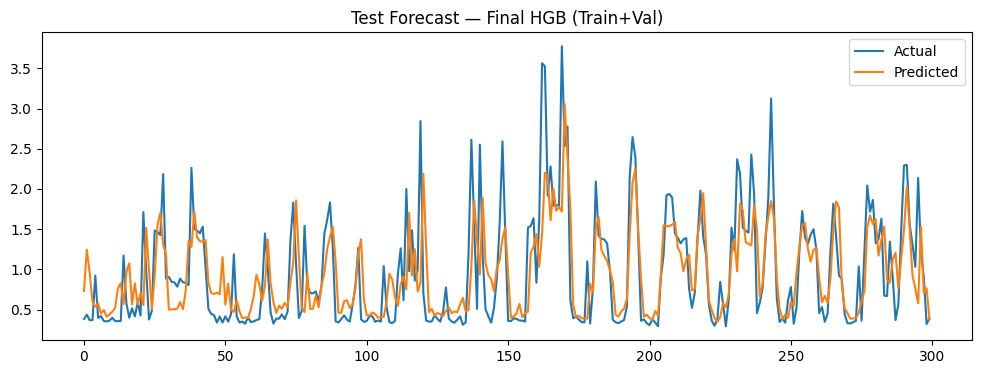

In [22]:
# test plot 
plt.figure(figsize=(12, 4))
plt.plot(y_test.values[:300], label="Actual")
plt.plot(y_test_pred[:300], label="Predicted")
plt.title("Test Forecast — Final HGB (Train+Val)")
plt.legend()
plt.show()

### Save Final Forecast Pipeline

In [23]:
MODEL_PATH = "../models/forecast_pipeline_v1.joblib"
joblib.dump(final_model, MODEL_PATH)

MODEL_PATH

'../models/forecast_pipeline_v1.joblib'